In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

import pickle
import os

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Getting Dataset

In [3]:
train_dataset = torchvision.datasets.FashionMNIST(root='./data', download= True, train = True, transform = transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST(root='./data', download= True, train = False, transform = transforms.Compose([transforms.ToTensor()]))

## Making the data 3d and 224x224

In [4]:
import torch.nn.functional as F
import numpy as np
from scipy.ndimage import zoom

length = len(train_dataset.data)
train_data = []

for x in range(length):

    test, target = train_dataset.__getitem__(x)
    
    test = test.unsqueeze(0)
    
    desired_shape = (224, 224)
    resized_image = F.interpolate(test, size=desired_shape, mode='bilinear', align_corners=False)
    
    resized_image = resized_image.squeeze(0).squeeze(0)
    resized_image = resized_image.numpy()

    new_image = np.array([resized_image,resized_image,resized_image])
    new_image = torch.tensor(new_image)
    
    train_data.insert(x, [new_image, target])

test_file = '3d_224_test.pkl'

with open(os.getcwd() + '/data/pickle_out/' + test_file, 'rb') as file:
    test_data = pickle.load(file)

In [ ]:
# FOR DUMPING OUT THE 3D TENSORS

# file_name = '3d_224_train.pkl' 

# with open(os.getcwd() + '/data/pickle_out/' + file_name, 'wb') as file:
#     pickle.dump(new_data, file)

In [5]:
from utils import FashionMnist_Dataset

train_dataset = FashionMnist_Dataset(train_data)
test_dataset = FashionMnist_Dataset(test_data)

BATCH_SIZE = 128

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [7]:
from utils import train_loop, test_loop, EarlyStopper
from pretrained_model import googleNet_pretrained

num_epochs = 60
lr = 0.001
patience = 5

early_stopper = EarlyStopper(patience=patience, min_delta=0)
model = googleNet_pretrained(train_last_layer_only= False)

model.to(device= device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

tr_acc, te_acc = [], []
tr_loss, te_loss = [], []

best_acc = 0

for epoch in range(num_epochs):
    train_loss, train_correct = train_loop(train_loader, model, loss_fn, optimizer, device)
    test_loss, test_correct = test_loop(test_loader, model, loss_fn, device)

    print('Train Acc epoch {} : {} '.format(epoch, train_correct))
    print('Test Acc epoch {} : {} '.format(epoch, test_correct))

    tr_acc.append(train_correct)
    te_acc.append(test_correct)

    tr_loss.append(train_loss)
    te_loss.append(test_loss)

    if early_stopper.early_stop(test_loss):
        print("Done! Early stopped at {}".format(epoch))
        break



Using cache found in C:\Users\ianch/.cache\torch\hub\pytorch_vision_v0.10.0


Train Acc epoch 0 : 0.8420333333333333 
Test Acc epoch 0 : 0.8899 
Train Acc epoch 1 : 0.8942 
Test Acc epoch 1 : 0.9098 
Train Acc epoch 2 : 0.9144833333333333 
Test Acc epoch 2 : 0.9305 
Train Acc epoch 3 : 0.9263833333333333 
Test Acc epoch 3 : 0.9344 
Train Acc epoch 4 : 0.9390333333333334 
Test Acc epoch 4 : 0.9451 
Train Acc epoch 5 : 0.9486 
Test Acc epoch 5 : 0.9533 
Train Acc epoch 6 : 0.9566833333333333 
Test Acc epoch 6 : 0.9604 
Train Acc epoch 7 : 0.9639333333333333 
Test Acc epoch 7 : 0.9573 
Train Acc epoch 8 : 0.96975 
Test Acc epoch 8 : 0.9446 
Train Acc epoch 9 : 0.9731666666666666 
Test Acc epoch 9 : 0.9634 
Train Acc epoch 10 : 0.97645 
Test Acc epoch 10 : 0.9599 
Train Acc epoch 11 : 0.9785333333333334 
Test Acc epoch 11 : 0.9692 
Train Acc epoch 12 : 0.9806333333333334 
Test Acc epoch 12 : 0.975 
Train Acc epoch 13 : 0.9828 
Test Acc epoch 13 : 0.9792 
Train Acc epoch 14 : 0.9842333333333333 
Test Acc epoch 14 : 0.9737 
Train Acc epoch 15 : 0.9857 
Test Acc epoch 

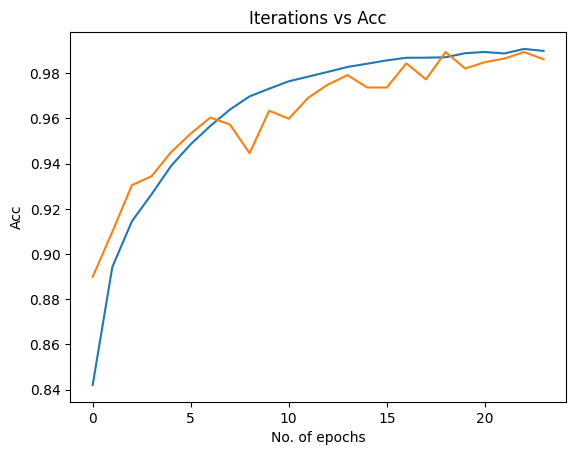

In [11]:
plt.plot(range(epoch+1), tr_acc)
plt.plot(range(epoch+1), te_acc)
plt.xlabel("No. of epochs")
plt.ylabel("Acc")
plt.title("Iterations vs Acc")
plt.show()

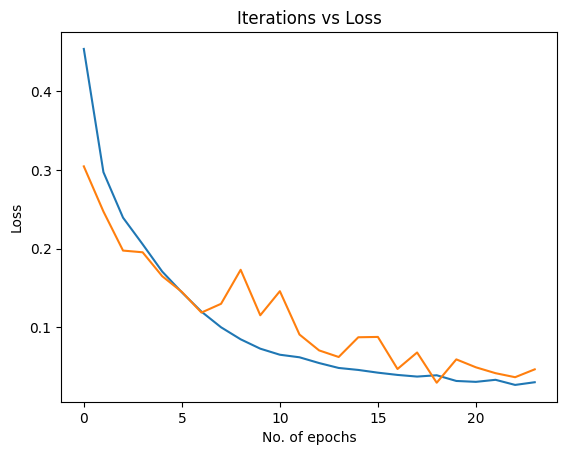

In [12]:
plt.plot(range(epoch+1), tr_loss)
plt.plot(range(epoch+1), te_loss)
plt.xlabel("No. of epochs")
plt.ylabel("Loss")

plt.title("Iterations vs Loss")
plt.show()

In [13]:
print("Best Acc : {} | Best Epoch : {}".format(max(te_acc), te_acc.index(max(te_acc))))

Best Acc : 0.9894 | Best Epoch : 18


## Pickle out results and accuracies

In [14]:
import pickle
import os

file_name = 'pretrained_googlenet_unfreeze.pkl' 

with open(os.getcwd() + '/results/' + file_name, 'wb') as file:
    pickle.dump(tr_acc, file)
    pickle.dump(te_acc, file)
    pickle.dump(tr_loss, file)
    pickle.dump(te_loss, file)

## Pickle in results and accuracies

In [15]:
file_name = 'pretrained_googlenet_unfreeze.pkl' 

with open(os.getcwd() + '/results/' + file_name, 'rb') as file:
    tr_acc = pickle.load(file)
    te_acc = pickle.load(file)
    tr_loss = pickle.load(file)
    te_loss = pickle.load(file)


print(tr_acc)
print(te_acc)
print(tr_loss)
print(te_loss)

[0.8420333333333333, 0.8942, 0.9144833333333333, 0.9263833333333333, 0.9390333333333334, 0.9486, 0.9566833333333333, 0.9639333333333333, 0.96975, 0.9731666666666666, 0.97645, 0.9785333333333334, 0.9806333333333334, 0.9828, 0.9842333333333333, 0.9857, 0.9868666666666667, 0.9869, 0.9870833333333333, 0.9889, 0.9894333333333334, 0.9887666666666667, 0.9907833333333333, 0.9899]
[0.8899, 0.9098, 0.9305, 0.9344, 0.9451, 0.9533, 0.9604, 0.9573, 0.9446, 0.9634, 0.9599, 0.9692, 0.975, 0.9792, 0.9737, 0.9737, 0.9844, 0.9773, 0.9894, 0.9821, 0.9849, 0.9865, 0.9894, 0.9862]
[0.4539341896834783, 0.29724150975283703, 0.23936005581675562, 0.20553365839910692, 0.17077942168516674, 0.14441650747307722, 0.11986084810852553, 0.09995775003782055, 0.08466551990749495, 0.07275770507576299, 0.06505188774009972, 0.06180197454411224, 0.05448366027852584, 0.04823133617738789, 0.04571720627575637, 0.04224015526449567, 0.03937546303991107, 0.03728256960236743, 0.03894853849388477, 0.031703032937102645, 0.0305610840